In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd


/home/as111/sipm-analysis


In [4]:
# data folder
path = "/scratch/gpfs/as111/results/2022-11-22/"
data_spe = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for pos in positions:
    data_spe[pos] = {}
    for ch in channels:
        data_spe[pos][ch] = {}
        for volt in voltages:
            data_spe[pos][ch][volt] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
            files = glob.glob(f"{path}/*volt_{volt}_pos_{pos}*_wf.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data_spe[pos][ch][volt]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
                if data_spe[pos][ch][volt]['time'].shape[0]==0:
                    data_spe[pos][ch][volt]['time'] = np.array(df['time'])
                if data_spe[pos][ch][volt]['avg_spe_wf'].shape[0]==0:
                    data_spe[pos][ch][volt]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
                else:
                    data_spe[pos][ch][volt]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            df = None
            data_spe[pos][ch][volt]['avg_spe_wf'] /= data_spe[pos][ch][volt]['n_spe_wfs']
print('keys: ', list(data_spe['top'][0][63].keys()))

keys:  ['n_spe_wfs', 'avg_spe_wf', 'time']


top ch0 63V 63604 waveforms selected
top ch0 65V 57580 waveforms selected
top ch0 67V 51528 waveforms selected
top ch0 69V 47122 waveforms selected
top ch0 71V 42582 waveforms selected
top ch1 63V 44717 waveforms selected
top ch1 65V 38749 waveforms selected
top ch1 67V 33119 waveforms selected
top ch1 69V 29974 waveforms selected
top ch1 71V 25953 waveforms selected
top ch2 63V 48227 waveforms selected
top ch2 65V 41733 waveforms selected
top ch2 67V 36132 waveforms selected
top ch2 69V 32584 waveforms selected
top ch2 71V 28589 waveforms selected
top ch3 63V 63201 waveforms selected
top ch3 65V 57378 waveforms selected
top ch3 67V 51817 waveforms selected
top ch3 69V 46732 waveforms selected
top ch3 71V 42262 waveforms selected
bottom ch0 63V 51767 waveforms selected
bottom ch0 65V 45033 waveforms selected
bottom ch0 67V 39703 waveforms selected
bottom ch0 69V 35163 waveforms selected
bottom ch0 71V 31184 waveforms selected
bottom ch1 63V 54996 waveforms selected
bottom ch1 65V 48947

Text(0.07, 0.5, 'Amplitude (ADC Unit)')

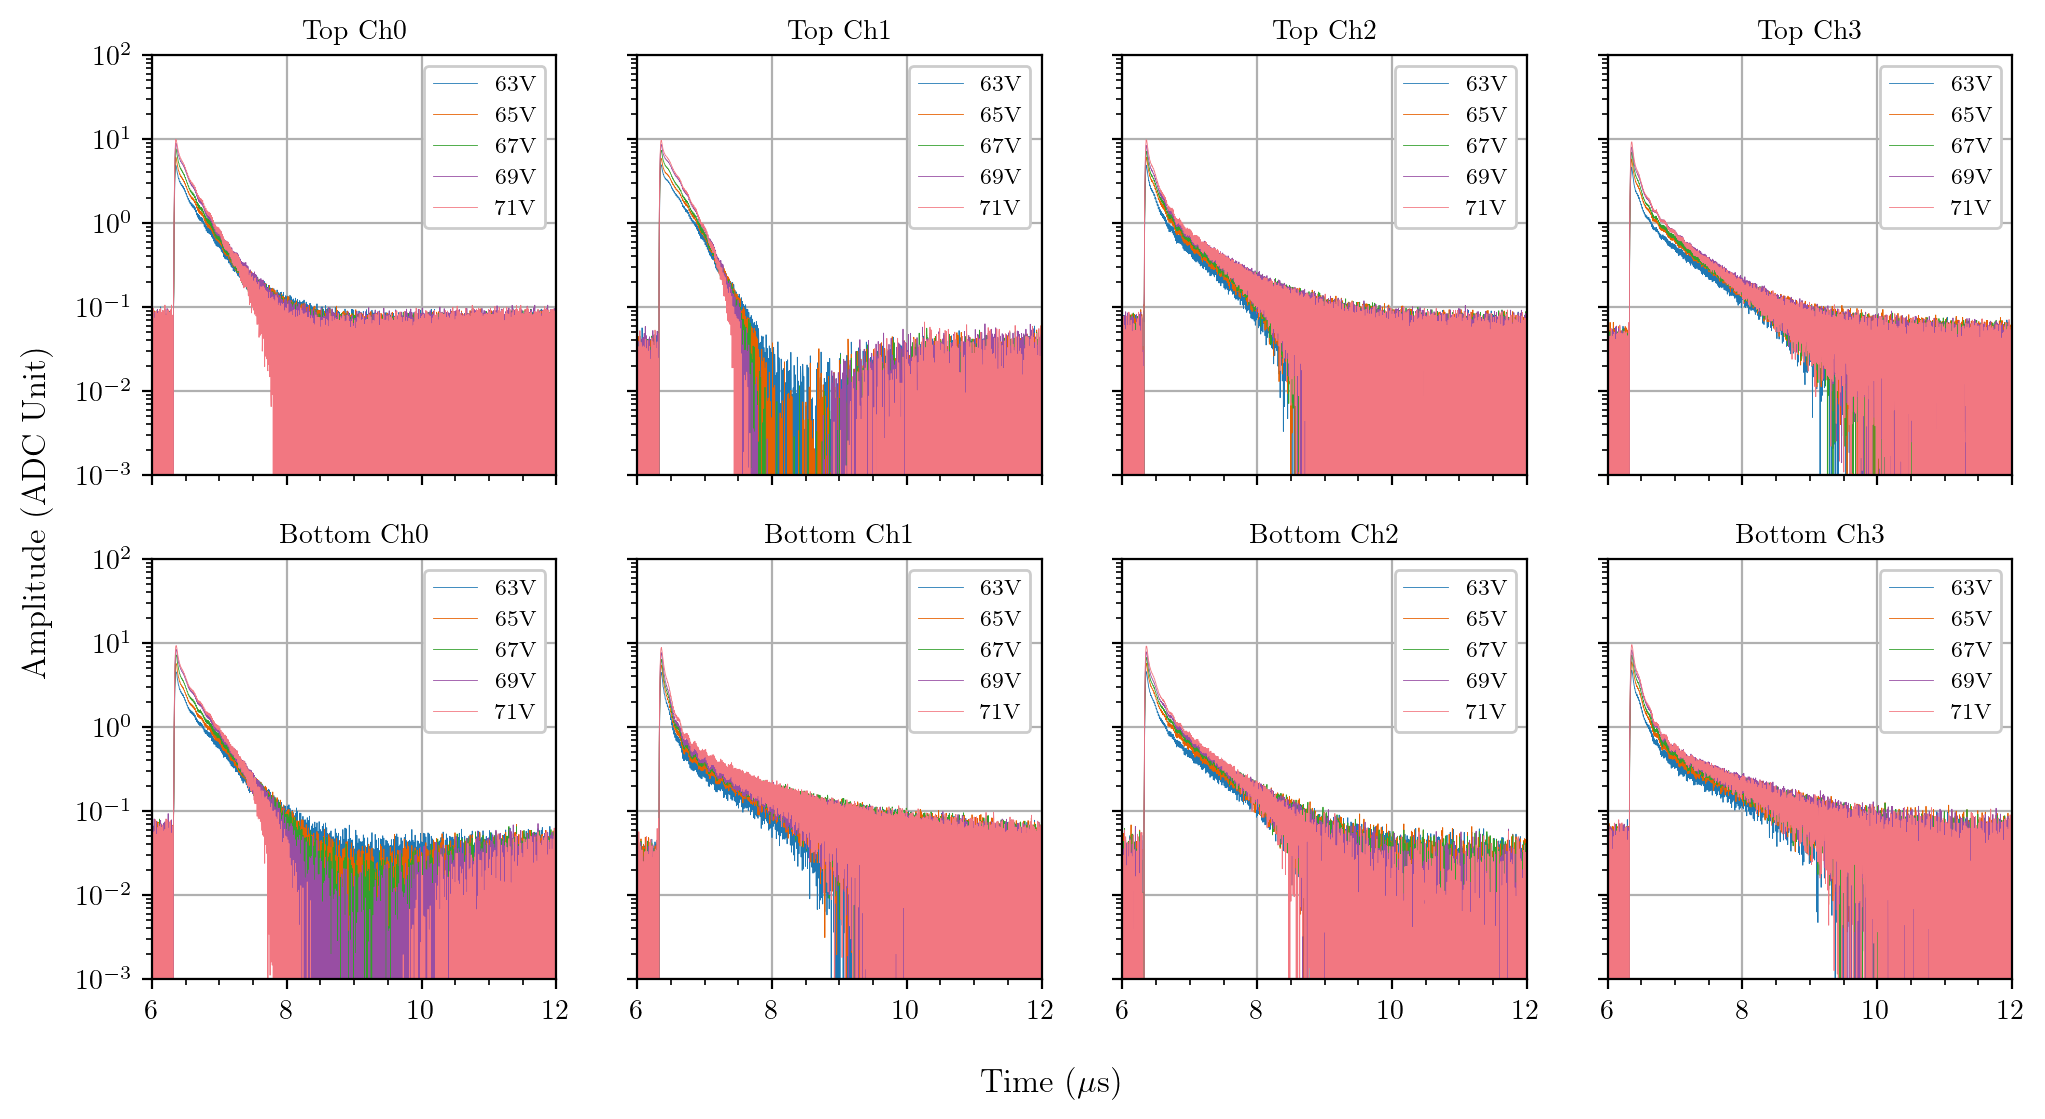

In [5]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V {data_spe[pos][ch][volt]["n_spe_wfs"]:.0f} waveforms selected')
            axs[i, j].plot(
                data_spe[pos][ch][volt]['time'],
                data_spe[pos][ch][volt]['avg_spe_wf'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [6]:
# data folder
path = "/scratch/gpfs/as111/results/2022-11-22/"
data_fft = {}
positions = ['top', 'bottom']
channels = [0, 1, 2, 3]
voltages = [63, 65, 67, 69, 71]
for pos in positions:
    data_fft[pos] = {}
    for ch in channels:
        data_fft[pos][ch] = {}
        for volt in voltages:
            data_fft[pos][ch][volt] = {
                'frequency_MHz':np.zeros(0),
                'n_0pe_wfs':0,
                'avg_0pe_psd':np.zeros(0),
                'n_1pe_wfs':0,
                'avg_1pe_psd':np.zeros(0)}
            files = glob.glob(f"{path}/*volt_{volt}_pos_{pos}*_fft.h5")
            for f in files:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                if data_fft[pos][ch][volt]['frequency_MHz'].shape[0]==0:
                    data_fft[pos][ch][volt]['frequency_MHz'] = np.array(df['frequency_MHz'])
                data_fft[pos][ch][volt]['n_0pe_wfs'] += np.array(df['n_0pe_wfs'])[0]
                if data_fft[pos][ch][volt]['avg_0pe_psd'].shape[0]==0:
                    data_fft[pos][ch][volt]['avg_0pe_psd'] = np.array(df['avg_0pe_psd'])*np.array(df['n_0pe_wfs'])[0]
                else:
                    data_fft[pos][ch][volt]['avg_0pe_psd'] += np.array(df['avg_0pe_psd'])*np.array(df['n_0pe_wfs'])[0]
                data_fft[pos][ch][volt]['n_1pe_wfs'] += np.array(df['n_1pe_wfs'])[0]
                if data_fft[pos][ch][volt]['avg_1pe_psd'].shape[0]==0:
                    data_fft[pos][ch][volt]['avg_1pe_psd'] = np.array(df['avg_1pe_psd'])*np.array(df['n_1pe_wfs'])[0]
                else:
                    data_fft[pos][ch][volt]['avg_1pe_psd'] += np.array(df['avg_1pe_psd'])*np.array(df['n_1pe_wfs'])[0]
            df = None
            data_fft[pos][ch][volt]['avg_0pe_psd'] /= data_fft[pos][ch][volt]['n_0pe_wfs']
            data_fft[pos][ch][volt]['avg_1pe_psd'] /= data_fft[pos][ch][volt]['n_1pe_wfs']

top ch0 63V 0pe:48186 events 1pe:63604 events
top ch0 65V 0pe:43377 events 1pe:57580 events
top ch0 67V 0pe:38961 events 1pe:51528 events
top ch0 69V 0pe:37295 events 1pe:47122 events
top ch0 71V 0pe:34911 events 1pe:42582 events
top ch1 63V 0pe:22947 events 1pe:44717 events
top ch1 65V 0pe:19685 events 1pe:38749 events
top ch1 67V 0pe:17248 events 1pe:33119 events
top ch1 69V 0pe:15764 events 1pe:29974 events
top ch1 71V 0pe:14582 events 1pe:25953 events
top ch2 63V 0pe:25691 events 1pe:48227 events
top ch2 65V 0pe:22213 events 1pe:41733 events
top ch2 67V 0pe:19254 events 1pe:36132 events
top ch2 69V 0pe:17928 events 1pe:32584 events
top ch2 71V 0pe:16401 events 1pe:28589 events
top ch3 63V 0pe:47222 events 1pe:63201 events
top ch3 65V 0pe:41846 events 1pe:57378 events
top ch3 67V 0pe:37889 events 1pe:51817 events
top ch3 69V 0pe:35899 events 1pe:46732 events
top ch3 71V 0pe:33616 events 1pe:42262 events
bottom ch0 63V 0pe:29108 events 1pe:51767 events
bottom ch0 65V 0pe:24958 events

Text(0.07, 0.5, 'Power Spectral Density (A.U.)')

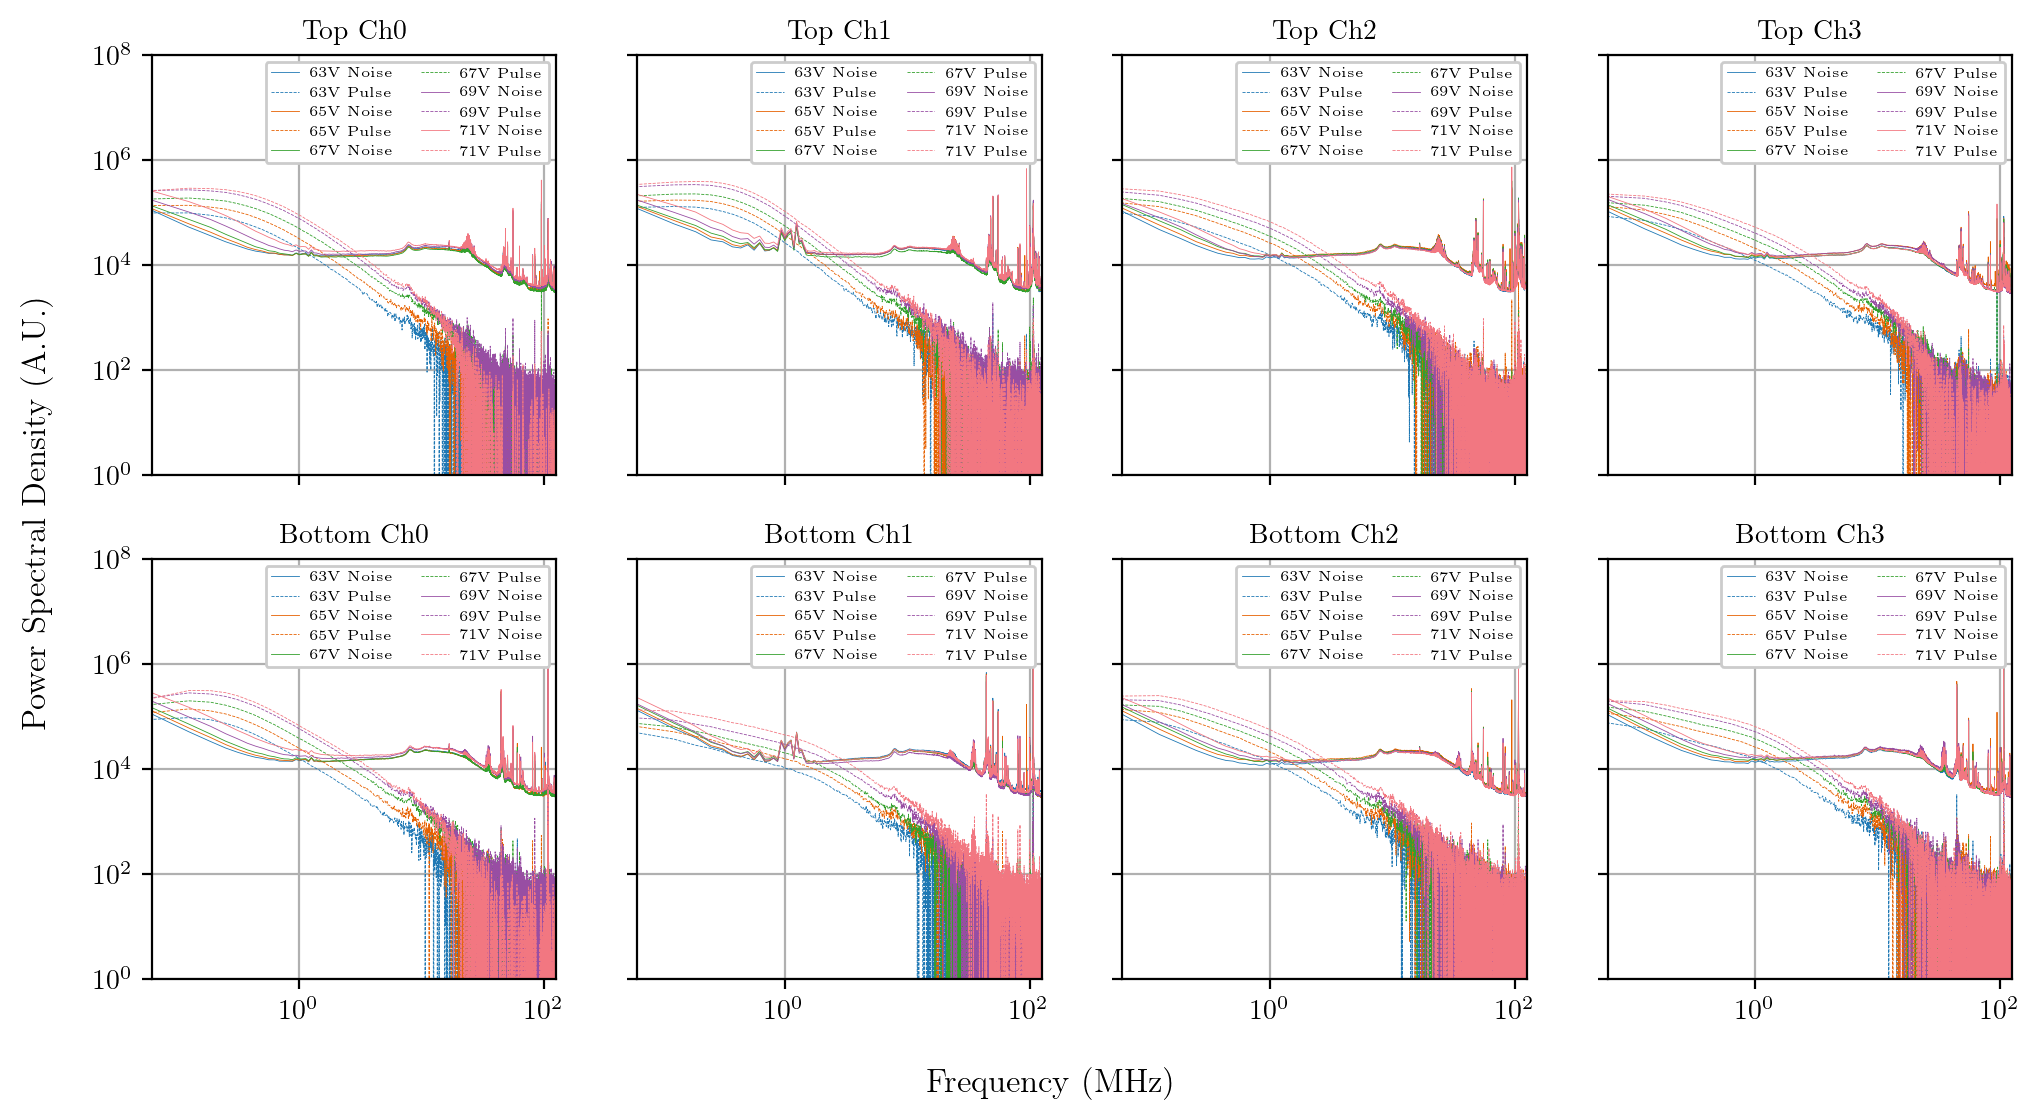

In [7]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            print(f'{pos} ch{ch} {volt}V 0pe:{data_fft[pos][ch][volt]["n_0pe_wfs"]:.0f} events 1pe:{data_fft[pos][ch][volt]["n_1pe_wfs"]:.0f} events')
            axs[i, j].plot(
                data_fft[pos][ch][volt]['frequency_MHz'],
                data_fft[pos][ch][volt]['avg_0pe_psd'],
                label=f'{volt}V Noise', color=f'C{k}', linewidth=0.3, linestyle='-')
            axs[i, j].plot(
                data_fft[pos][ch][volt]['frequency_MHz'],
                data_fft[pos][ch][volt]['avg_1pe_psd']-data_fft[pos][ch][volt]['avg_0pe_psd'],
                label=f'{volt}V Pulse', color=f'C{k}', linewidth=0.3, linestyle='--')
        axs[i, j].legend(loc='upper right', ncol=2, fontsize=5)
        axs[i, j].set_xlim(1./16, 125)
        axs[i, j].set_ylim(1e0, 1e8)
        axs[i, j].set_yscale('log')
        axs[i, j].set_xscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'Power Spectral Density (A.U.)', x=0.07)

# Wiener deconvolution filter
The Wiener deconvolution filter is given by
$$G_{w}(f)=\frac{1}{H(f)}\frac{|H(f)|^2 S(f)}{|H(f)|^2 S(f) + N(f)},$$
where $H(f)$ is the response function, $N(f)$ is the noise power spectrum, and $S(f)$ is the original signal power spectrum. We assume $S(f)=1$ fow now. The Wiener filter minimizes the sum of square errors between the original signal (unconvoluted by the SiPM response, that is, the photon arrival time distribution) and the filtered signal.

Text(0.07, 0.5, 'Wiener factor $|H|^2/(|H|^2+N)$')

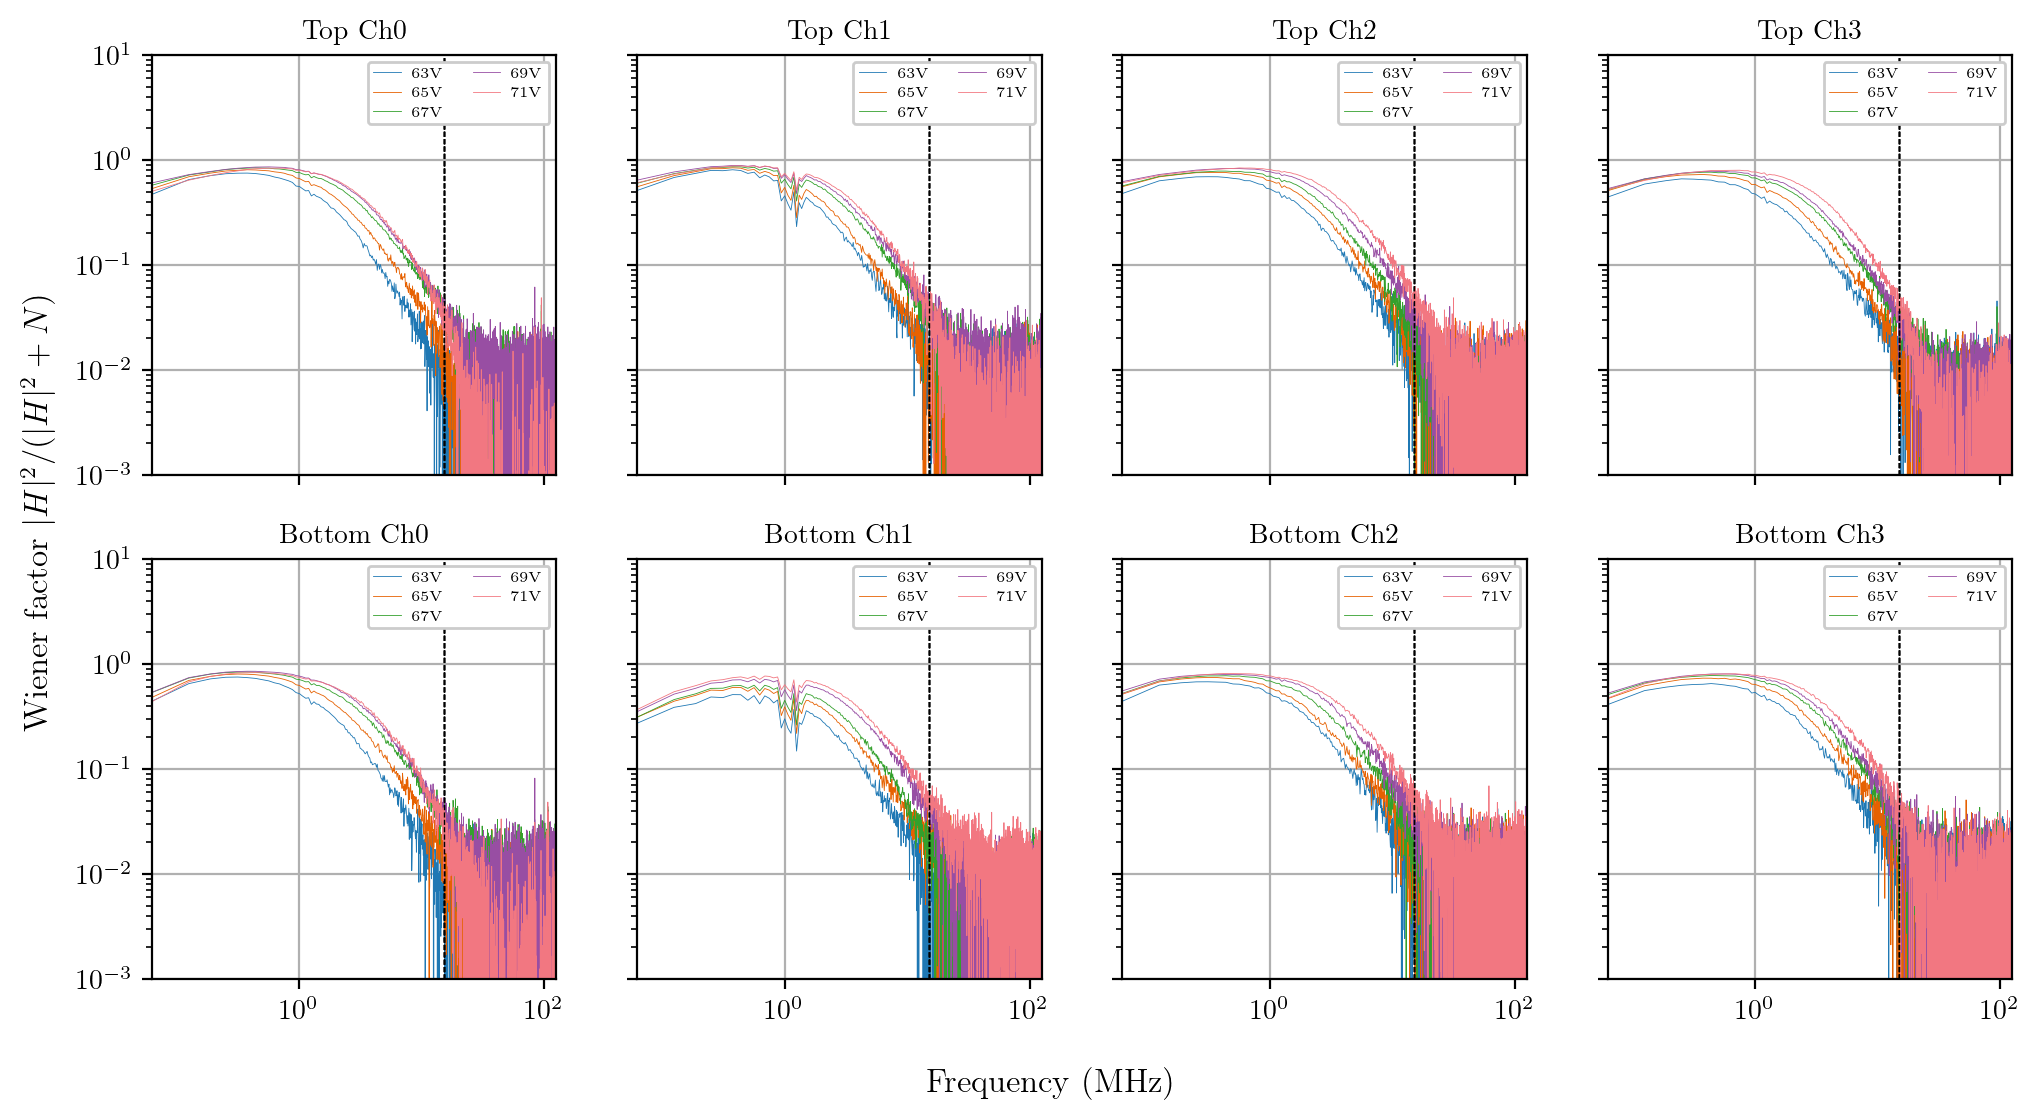

In [8]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
yrange=(1e-3,1e1)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_fft[pos][ch][volt]['wiener_factor'] = 1-data_fft[pos][ch][volt]['avg_0pe_psd']/data_fft[pos][ch][volt]['avg_1pe_psd']
            axs[i, j].plot(
                data_fft[pos][ch][volt]['frequency_MHz'],
                data_fft[pos][ch][volt]['wiener_factor'],
                label=f'{volt}V', color=f'C{k}', linewidth=0.3, linestyle='-')
            cutoff_MHz = 15
            axs[i, j].plot([cutoff_MHz]*2, yrange, 'k--', linewidth=0.5)
            data_fft[pos][ch][volt]['wiener_factor'][ (data_fft[pos][ch][volt]['frequency_MHz']>cutoff_MHz) & ((data_fft[pos][ch][volt]['frequency_MHz']<data_fft[pos][ch][volt]['frequency_MHz'][-1]+data_fft[pos][ch][volt]['frequency_MHz'][1]-cutoff_MHz)) ] = 0
        axs[i, j].legend(loc='upper right', ncol=2, fontsize=5)
        axs[i, j].set_xlim(1./16, 125)
        axs[i, j].set_ylim(yrange[0], yrange[1])
        axs[i, j].set_yscale('log')
        axs[i, j].set_xscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'Wiener factor $|H|^2/(|H|^2+N)$', x=0.07)

# FFT on the averaged waveform
This is to estimate $H(f)$ including the phase.

Text(0.07, 0.5, 'FFT Abs. Amplitude (ADC Unit)')

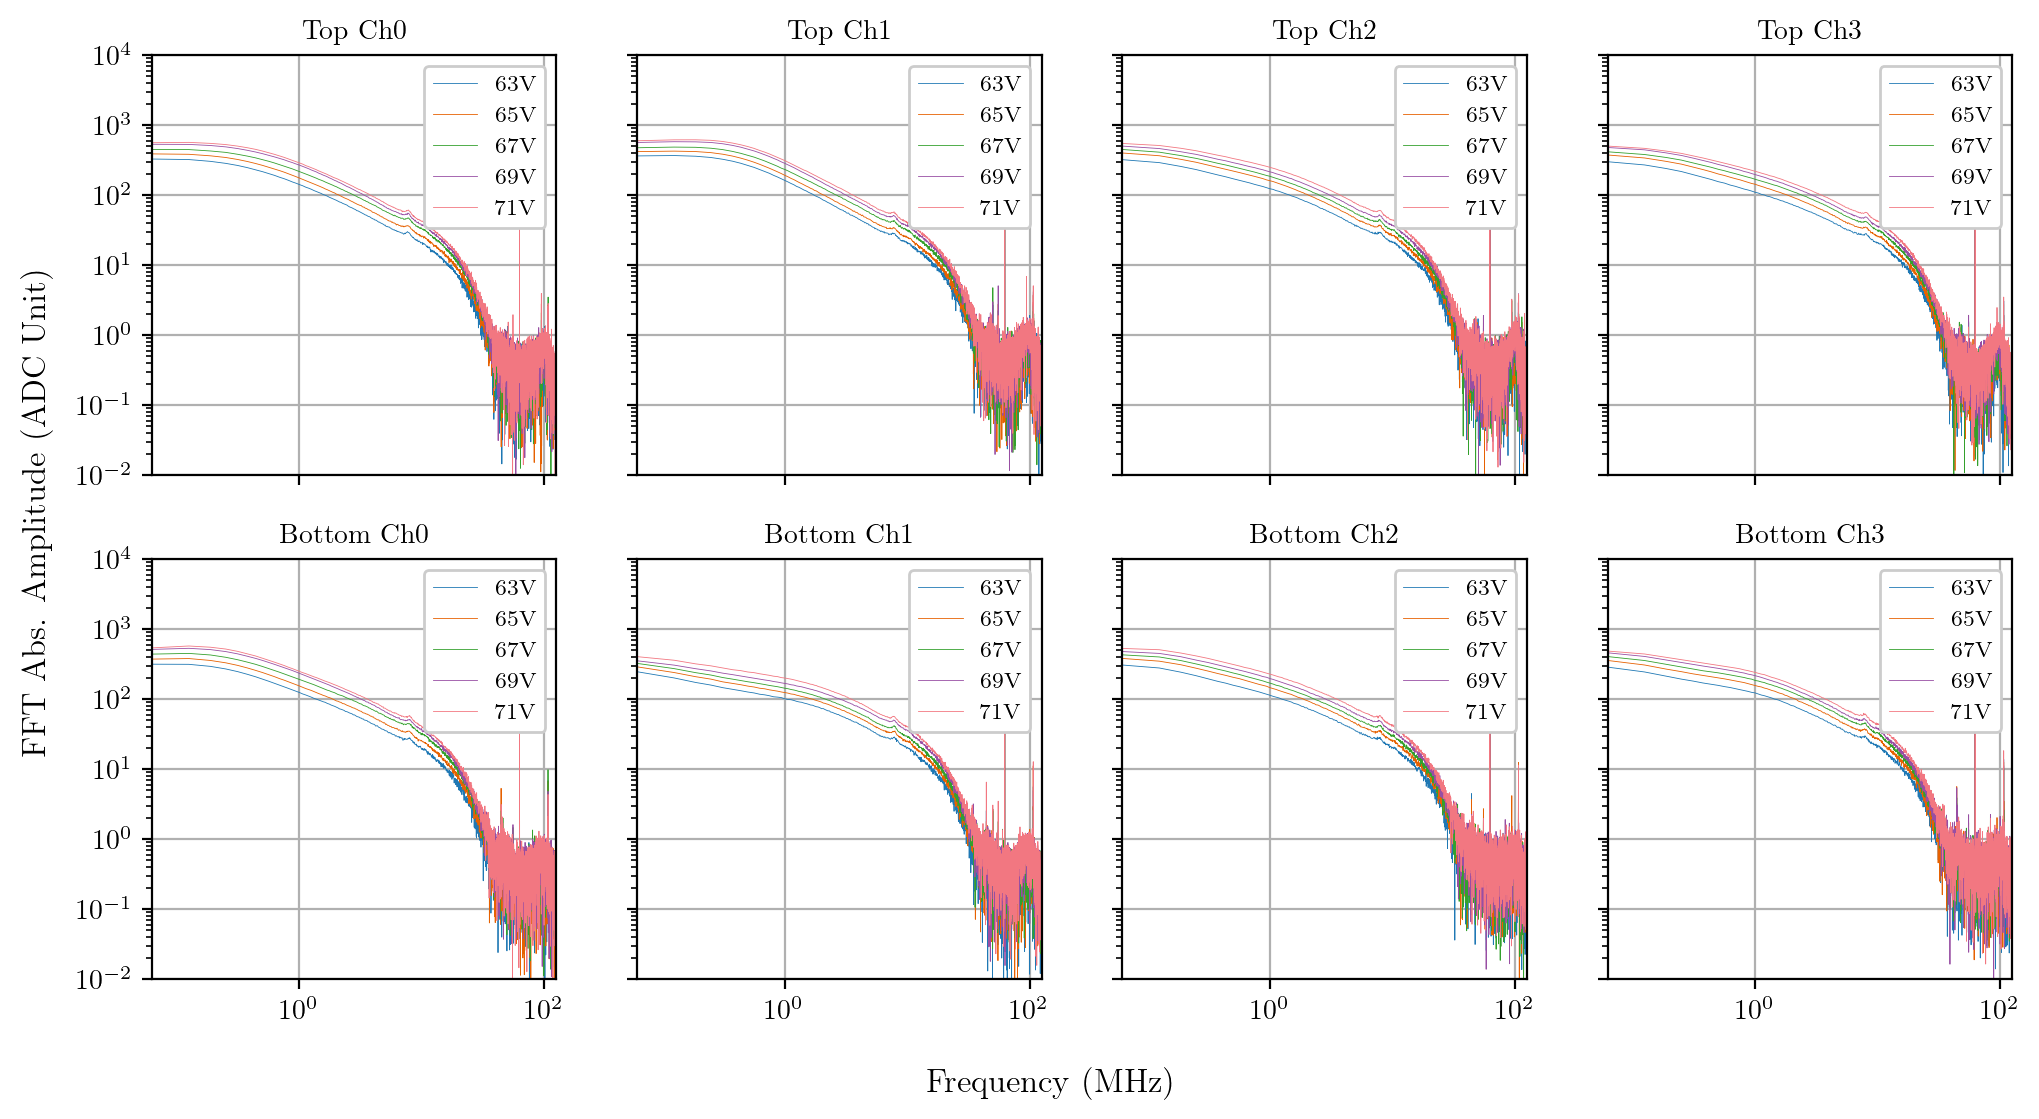

In [9]:
# Make plots for all datasets
# SPE average waveform
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            data_spe[pos][ch][volt]['fft_spe_wf'] = scipy.fft.fft(data_spe[pos][ch][volt]['avg_spe_wf'])
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            t_total = dt+data_spe[pos][ch][volt]['time'][-1]
            n_over_2 = int(data_spe[pos][ch][volt]['time'].shape[0]/2)
            data_spe[pos][ch][volt]['frequency'] = data_spe[pos][ch][volt]['time']/dt/t_total
            axs[i, j].plot(
                data_spe[pos][ch][volt]['frequency'][:n_over_2],
                abs(data_spe[pos][ch][volt]['fft_spe_wf'][:n_over_2]),
                label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_xlim(data_spe[pos][ch][volt]['frequency'][1], data_spe[pos][ch][volt]['frequency'][n_over_2])
        # axs[i, j].set_xlim(0,5)
        axs[i, j].set_ylim(1e-2, 1e4)
        axs[i, j].set_xscale('log')
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{pos[0].upper()}{pos[1:]} Ch{ch}')
fig.supxlabel(r'Frequency (MHz)', y=0.01)
fig.supylabel(r'FFT Abs. Amplitude (ADC Unit)', x=0.07)

# Compute Wiener filter and save as .h5

In [10]:
# Compute Wiener filter
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(np.argmax(data_spe[pos][ch][volt]['avg_spe_wf'])))) for freq in data_spe[pos][ch][volt]['frequency']])
            data_fft[pos][ch][volt]['wiener_filter'] = data_fft[pos][ch][volt]['wiener_factor']*shift/data_spe[pos][ch][volt]['fft_spe_wf']

In [11]:
h5filename = 'data/deconvolution_liq2.h5'
for pos in positions:
    for ch in channels:
        for volt in voltages:
            store = pd.HDFStore(h5filename)
            store.put(f'{pos}/ch{ch}/{volt}V',pd.DataFrame.from_dict(data_fft[pos][ch][volt]))
            store.close()

/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '63V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '65V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '67V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getatt

# Read from .h5

/home/as111/miniconda3/envs/sipm/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


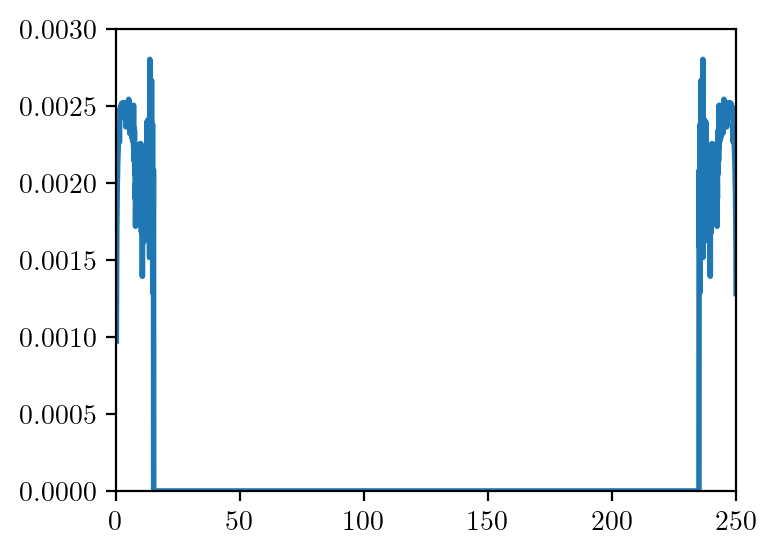

In [12]:
filter_h5 = pd.HDFStore(h5filename)
plt.plot(np.array(filter_h5['/top/ch0/67V']['frequency_MHz']), np.array(filter_h5['/top/ch0/67V']['wiener_filter']))

# Matched filter
The matched filter maximizes the signal-to-noise ratio. It is given by
$$G_{m}(f)=\frac{H(f)^\ast}{N(f)}.$$

In [14]:
# Compute matched filter
for i, pos in enumerate(positions):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
            shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(np.argmax(data_spe[pos][ch][volt]['avg_spe_wf'])))) for freq in data_spe[pos][ch][volt]['frequency']])
            data_fft[pos][ch][volt]['matched_filter'] = shift*np.conjugate(data_spe[pos][ch][volt]['fft_spe_wf'])/data_fft[pos][ch][volt]['avg_0pe_psd']

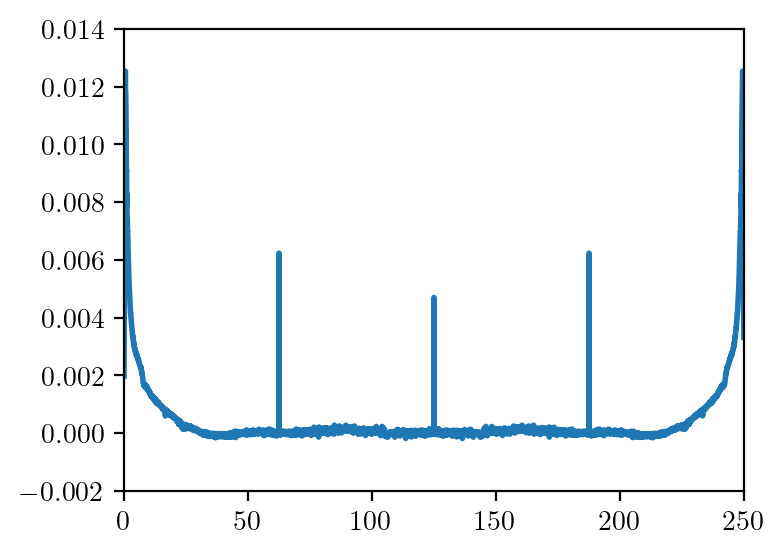

In [17]:
plt.plot(np.array(filter_h5['/top/ch0/67V']['frequency_MHz']), np.array(data_fft['top'][0][67]['matched_filter']))

# Try some scintillation waveforms

No time.txt file
/scratch/gpfs/GALBIATI/data/sipm//reflector_studies/2022-11-20/2022-11-20_volt_67_pos_bottom_light_scintillation_coinc_000_cond_gamma/0/wave3.dat
50541 events


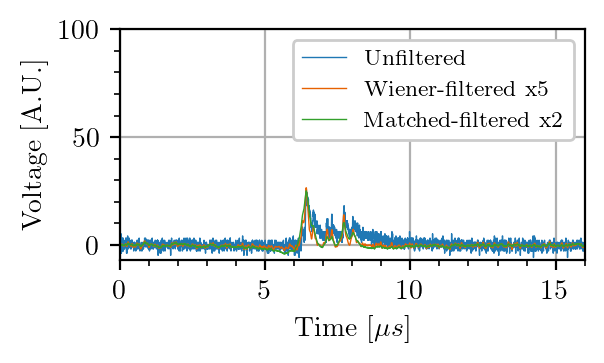

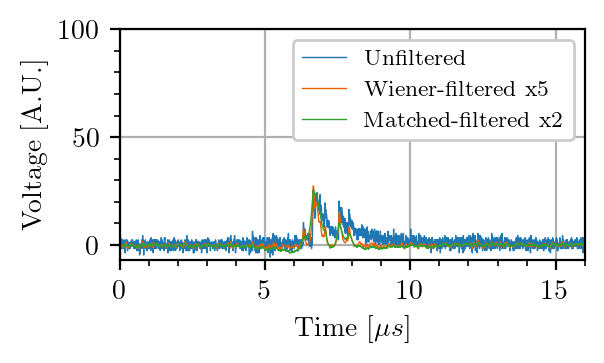

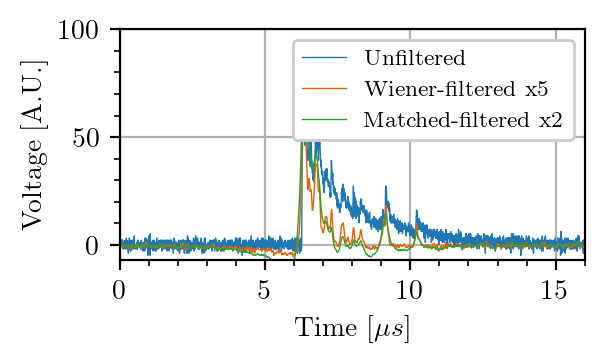

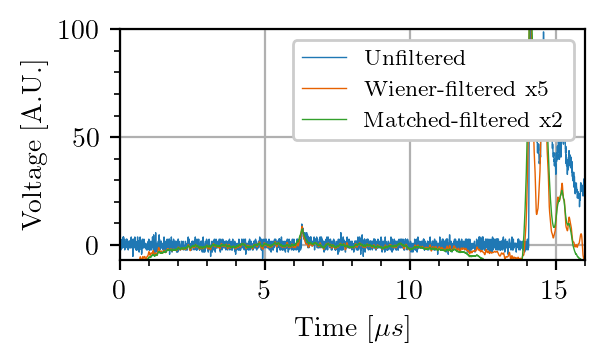

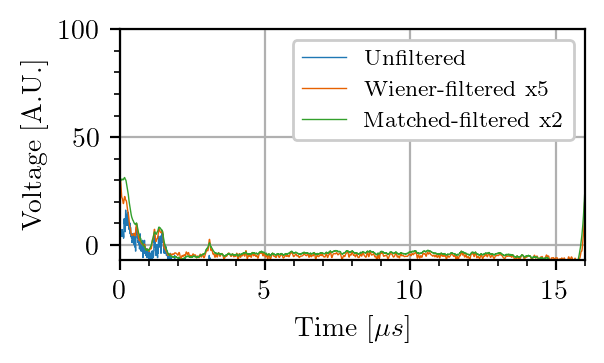

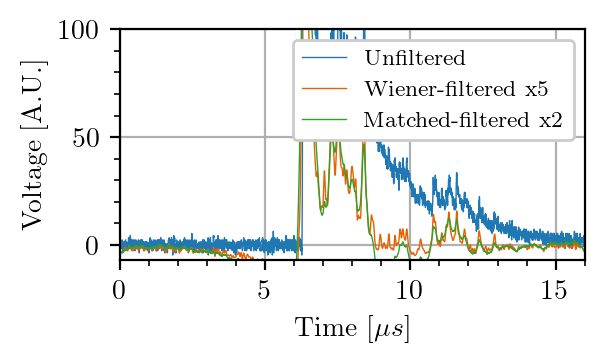

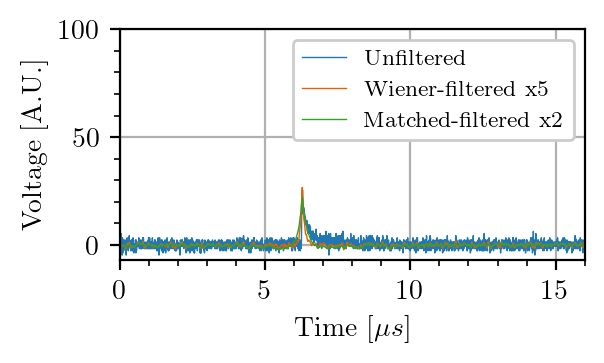

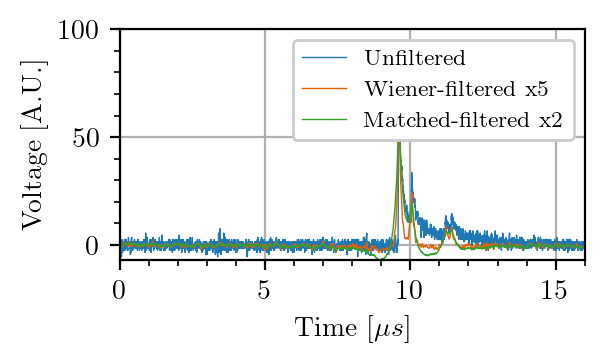

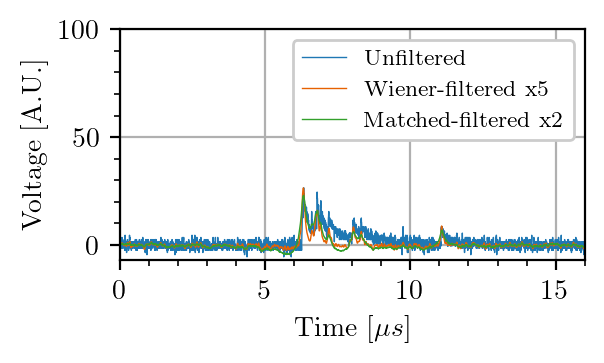

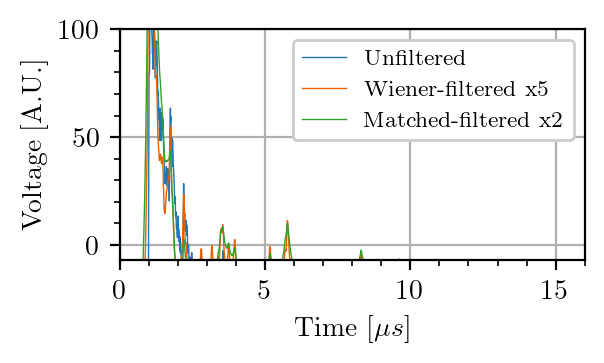

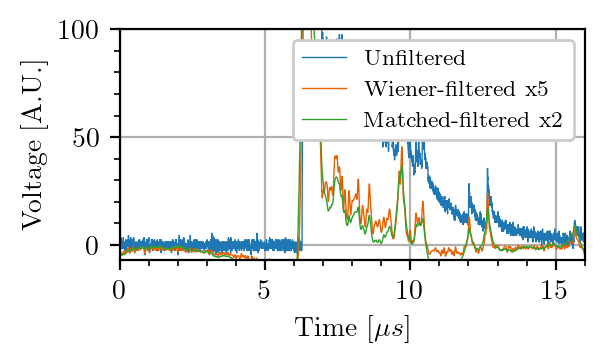

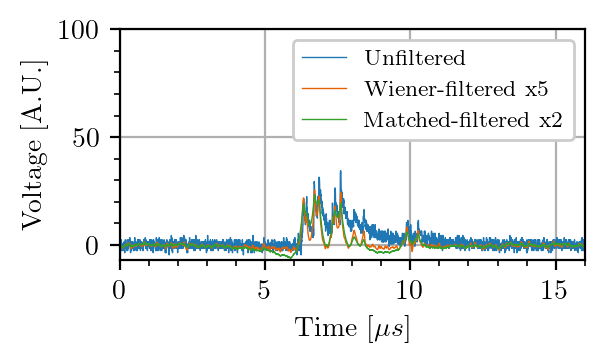

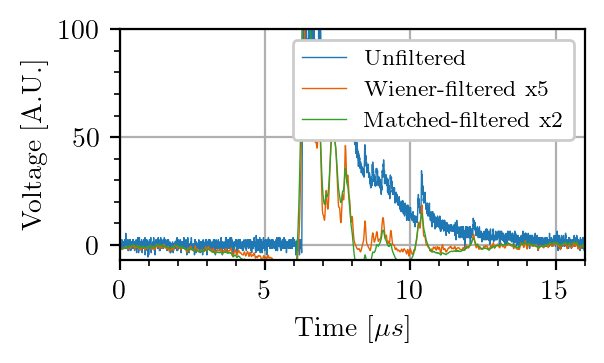

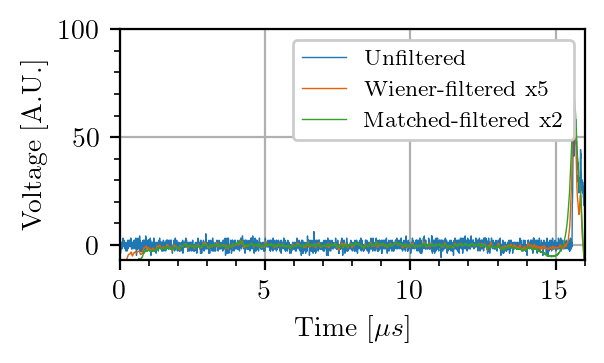

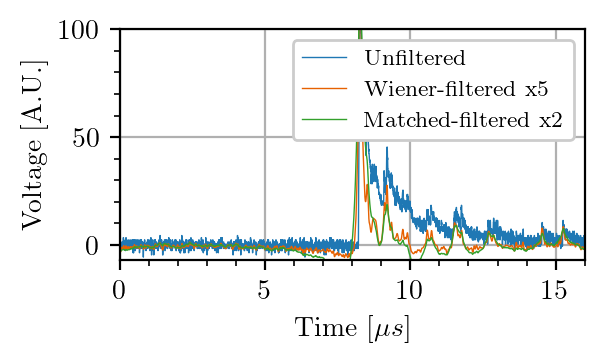

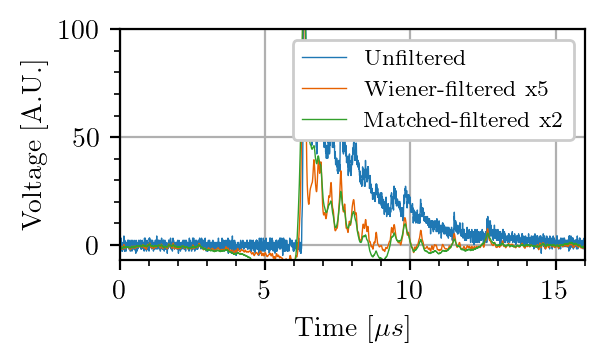

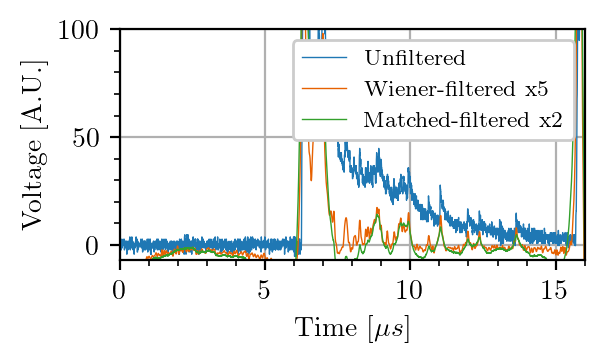

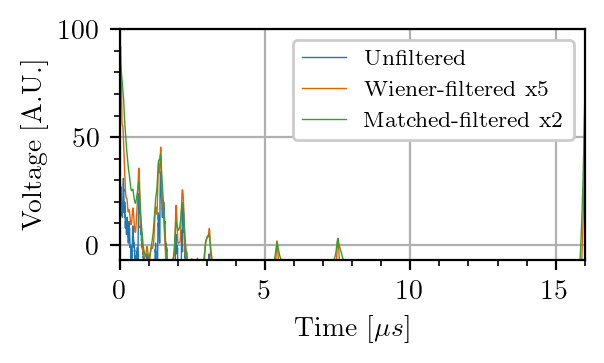

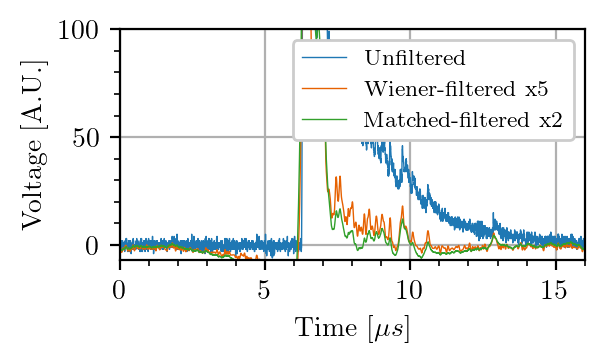

In [16]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/'
direc = '2022-11-20/2022-11-20_volt_67_pos_bottom_light_scintillation_coinc_000_cond_gamma/0/'
ch = 3
volt = 67
pos = 'bottom'
evid = np.arange(0, 100)
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir, direc), pol=-1, channels=range(4), samples=4000)
wfs, _ = dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)

for i, wf in enumerate(wfs):
    wiener = np.sqrt(len(wf))*scipy.fft.ifft(scipy.fft.fft(np.array(wf))*data_fft[pos][ch][volt]['wiener_filter']).real
    # dt = data_spe[pos][ch][volt]['time'][1]-data_spe[pos][ch][volt]['time'][0]
    # shift = np.array([np.exp(complex(0,-2*np.pi*freq*dt*int(np.argmax(data_spe[pos][ch][volt]['avg_spe_wf'])))) for freq in data_spe[pos][ch][volt]['frequency']])
    # cutoff_MHz = 15
    # cutoff = (data_fft[pos][ch][volt]['frequency_MHz']<cutoff_MHz) | ((data_fft[pos][ch][volt]['frequency_MHz']>data_fft[pos][ch][volt]['frequency_MHz'][-1]+data_fft[pos][ch][volt]['frequency_MHz'][1]-cutoff_MHz))
    # simple_deconv = np.sqrt(len(wf))*scipy.fft.ifft(scipy.fft.fft(np.array(wf))*shift/data_spe[pos][ch][volt]['fft_spe_wf']*cutoff).real
    matched = np.sqrt(len(wf))*scipy.fft.ifft(scipy.fft.fft(np.array(wf))*data_fft[pos][ch][volt]['matched_filter']).real
    if np.amax(wiener>5):
        plt.figure(i, figsize=(3, 1.5))
        plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
        plt.plot(dset.ch[ch].time, wiener*5, label='Wiener-filtered x5', linewidth=0.5)
        plt.plot(dset.ch[ch].time, matched*2, label='Matched-filtered x2', linewidth=0.5)
        # plt.plot(dset.ch[ch].time, simple_deconv, label='Simple+cut-off', linewidth=0.5)
        plt.legend(loc='upper right')
        plt.xlabel(r'Time [$\mu s$]')
        plt.ylabel(r'Voltage [A.U.]')
        plt.minorticks_on()
        plt.grid()
        plt.xlim(0, 16)
        plt.ylim(-7, 100)